## Step1)

Import the necessary packages and read the data file. 

In [2]:
# The import command allows us to call on various libraries
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.geocoders import MapBox
import matplotlib.pyplot as plt
# You need this to query mapbox
api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2twY3g4aXloMWFlcDJzbXN3aG95aG5uZiJ9.mFiJt0MIfL1MiJ2rB2xhKQ"

if api_key == "":
    print('Please enter your API key to continue!')
else:
    BC_Data = pd.read_csv('Data/BC_Data.csv',index_col='id_victim',parse_dates=['date'])
BC_Data.head()

,date,first_name,last_name,middle_name,alias_nickname,age,gender,race,prov,department,...,injured_officer,excited_delirium,mentral_distress_disorder,substance_abuse,charge_type,charges,officers involved,Check,Inquest date,extra_source
id_victim,,,,,,,,,,,,,,,,,,,,,
MR_225,2021-05-20,Unspecified,Unspecified,NaN,NaN,NaN,Female,Unspecified,BC,RCMP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validated,NaN,NaN
1809_KCC,2021-05-12,Unspecified,Unspecified,NaN,NaN,NaN,Unspecified,Unspecified,BC,RCMP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validated,NaN,NaN
MR_221,2021-05-01,Unspecified,NaN,NaN,NaN,NaN,Female,Unspecified,BC,Vancouver Police Department,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validated,NaN,NaN
MR_210,2021-02-27,Julian,Jones,NaN,NaN,28.0,Male,Indigenous,BC,RCMP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validated,NaN,NaN
MR_195,2021-01-05,Unspecified,NaN,NaN,NaN,37.0,Male,Unspecified,BC,Vancouver Police Department,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validated,NaN,NaN


## Fill the "missing" data values

By default, missing values are interpreted as "NaN" - the equivalent of "NODAT" in ArcGIS Pro
This works for the numeric data ('Age') but it cuases issues for the text data.

In [3]:
print('Total Incidents')
print(BC_Data.count()['date'])
print()

print('Total incidents by department')
print(BC_Data.groupby('department').count()['date'].sort_values(ascending=False))
print()


Total Incidents
147

Total Incidents by Department
department
RCMP                                                             89
Vancouver Police Department                                      18
Victoria Police Department                                        6
Mountain Penitentiary                                             3
Surrey Pretrial Service Centre                                    3
South Coast British Columbia Transit Authority Police Service     2
Pacific Institute                                                 2
Off Duty                                                          2
North Fraser Pretrial Centre                                      2
Matsqui Institution                                               2
Kent Institution                                                  2
Kamloops Regional Correctional Centre                             2
Fraser Regional Correctional Centre                               2
Delta Police Department                               

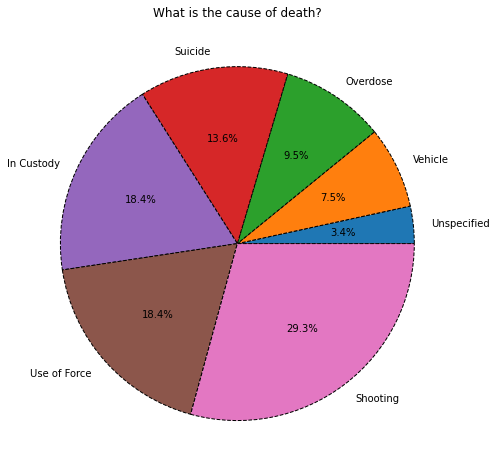

In [11]:
Deaths = BC_Data.groupby(['cause_death']).count()['date'].sort_values()
fig,ax=plt.subplots(figsize=(7,7))
ax.pie(
    Deaths,#['date'],
    labels=Deaths.index,
    textprops={'fontsize': 10},
#     colors=[Pie_Colors[i] for i in Armed.index],
    autopct='%1.1f%%',
    wedgeprops={"edgecolor":"k",'linewidth': 1,
                'linestyle': 'dashed',
               }
)
ax.set_title('What is the cause of death?')
plt.tight_layout()

# Geocoding

In [331]:
BC_Data['latitude'] = np.nan
BC_Data['longitude'] = np.nan
BC_Data['geocoding_Notes'] = ''

geolocator = MapBox(api_key=api_key)

i = 0
for index, row in BC_Data.iterrows():
    attempt = ' '.join([row['address_intersection'], row['city_town'], row['prov'], row['postal_code'],'Canada'])
    try:
        g = geolocator.geocode(attempt,timeout=3)
        BC_Data.loc[BC_Data.index==index,['latitude','longitude']]=g.latitude,g.longitude
    except:
        Police_Killings.loc[Police_Killings['postal_code']==row['postal_code'],'geocoding_Notes']='Geocoding Failed'
        pass
    i += 1
save_to = 'Data/BC_Geocoded.csv'
BC_Data.to_csv(save_to)

Failures = BC_Data.loc[BC_Data['geocoding_Notes']=='Geocoding Failed']
print('Filed to Geocode: ',Failures.count()['date'], ' records.')
print('Geocoding Done')
print('File saved to: ',save_to)

Filed to Geocode:  0  records.
Geocoding Done
File saved to:  Data/BC_Geocoded.csv


## Inspect the Outputs

Its always immportant to inspect the outputs when geocoding

In [338]:
# Create a webmap centered on BC at zoom level 5 with a simple black/white map tile   
Map = folium.Map(location=[53, -125],zoom_start=5,tiles='Stamen Toner')

# loop through all records and plot them
for index, row in BC_Data.iterrows():
    # Cricle marker takes multiple arguments [latitude and longitude] are required.
    # The others are optoional for styling our map
    folium.CircleMarker(location=[row['latitude'],row['longitude']],
                        # Popup text to appear on click
                        popup=row['address_intersection']+' '+row['city_town'],
                        # fill color for circle
                        fill_color='red',
                        # outline clor for circle
                        color='black'
                       ).add_to(Map)
    
Map.save('PoliceViolenceIncidents_BC.html')
# print('Map Saved!')
    
# Display the map
Map

# Importing Census Data


<IPython.core.display.Javascript object>


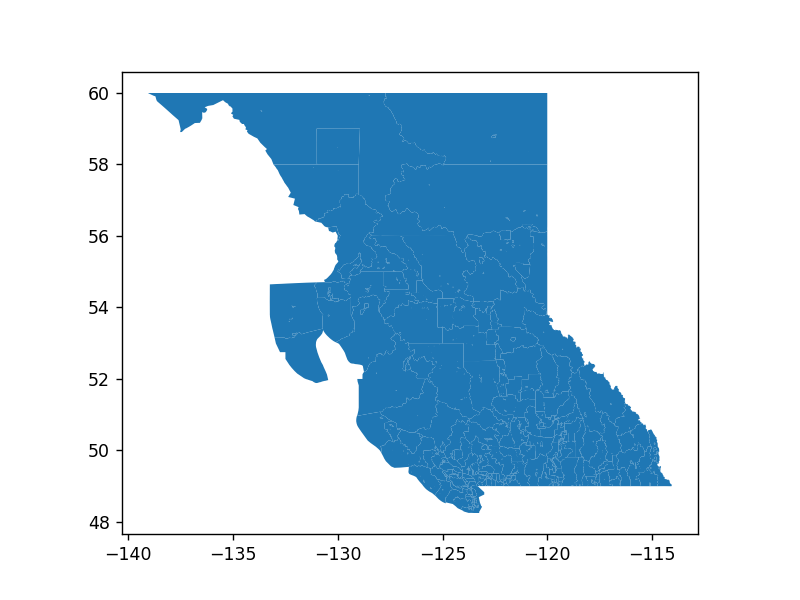

<AxesSubplot:>

In [228]:
# the .read_file() function reads shapefiles
file_name='Data/CensusSubdivisions/SimplyAnalytics_Shapefiles_2021-06-04_04_40_18_c765599d6ce1e70cd26026412f68ed7c.shp'
BC_csd = gpd.read_file(file_name)

BC_csd = BC_csd.rename(columns={
'VALUE0': 'Population, 2016',
                    })
BC_csd.plot()


<IPython.core.display.Javascript object>


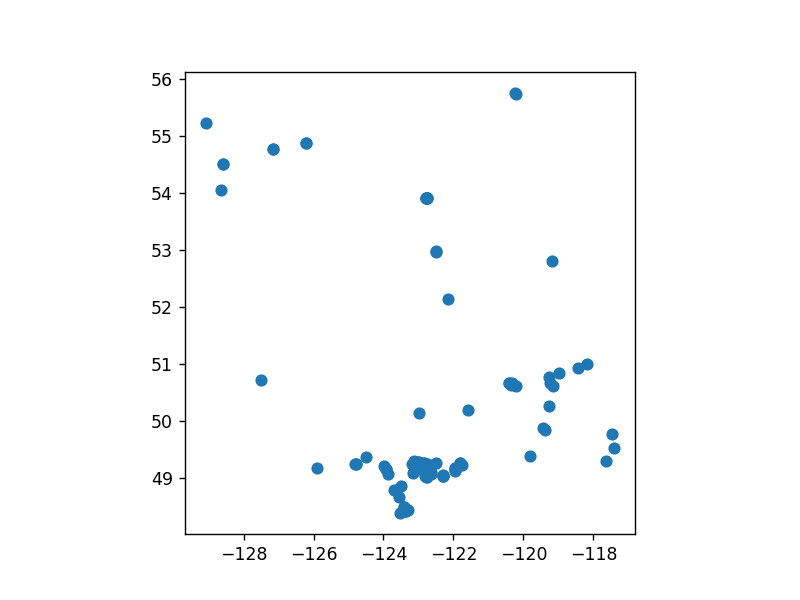

<AxesSubplot:>

In [303]:
BC_Data = pd.read_csv('Data/BC_Geocoded.csv',index_col='id_victim',parse_dates=['date'])
BC_Data_dgf = gpd.GeoDataFrame(BC_Data,
    geometry=gpd.points_from_xy(BC_Data.longitude,
                                BC_Data.latitude,
                                crs=CRS("WGS84")
                               ))
BC_Data_dgf.plot()

<IPython.core.display.Javascript object>


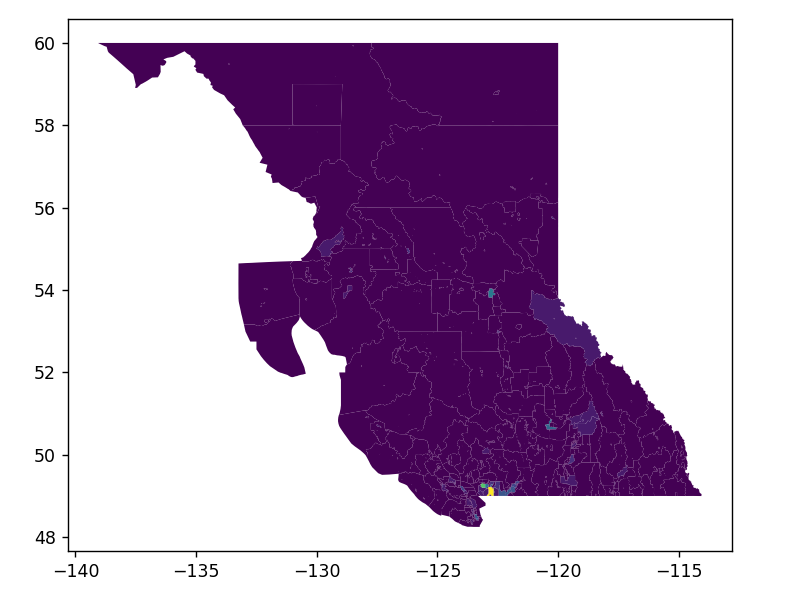

<AxesSubplot:>

In [230]:
BC_csd['Incidents'] = 0
for i,row in BC_csd.iterrows():
    pip = BC_Data_dgf.within(row['geometry'])
    if pip.sum()>0:
        BC_csd.loc[BC_csd.index==i,'Incidents']+=pip.sum()
BC_csd.plot(column='Incidents')

In [243]:
BC_csd['rate']=BC_csd['Incidents'].astype('float')/BC_csd['Population, 2016']/11*1e6
BC_csd=BC_csd.sort_values('rate').dropna()
print(BC_csd.loc[BC_csd['rate']>0,['name','rate','Population, 2016']].sort_values(by='rate'))

                                          name         rate  Population, 2016
145                         Richmond, BC (CSD)     0.420253          216320.0
140  Langley (District municipality), BC (CSD)     0.689499          131848.0
144                            Delta, BC (CSD)     0.775880          117169.0
149                  New Westminster, BC (CSD)     1.114519           81568.0
150                        Coquitlam, BC (CSD)     1.119577          162399.0
452                          Kelowna, BC (CSD)     1.270141          143148.0
147                        Vancouver, BC (CSD)     1.465408          682404.0
161                      Maple Ridge, BC (CSD)     1.975082           92056.0
463                           Vernon, BC (CSD)     2.083733           43628.0
148                          Burnaby, BC (CSD)     2.100204          259715.0
86                        Abbotsford, BC (CSD)     2.297933          158245.0
142                           Surrey, BC (CSD)     2.372957     

In [250]:
# g = geolocator.geocode('British Columbia, Canada',timeout=3)
Map = folium.Map(
    location=[g.latitude,g.longitude],#['49.260438','-123.088896'],
    zoom_start=5,
    tiles='Stamen Toner'
)
BC_csd_select=BC_csd.loc[((BC_csd['rate']>0)&((BC_csd['Population, 2016']>1000)))]
BC_csd_select.to_file("Data/BC_csd_select.json", driver = "GeoJSON")
folium.features.Choropleth('Data/BC_csd_select.json',
                           # It will match the geometry data up with a pandas or geopandas dataframe
                            data=BC_csd_select,
                            columns=['spatial_id','rate'],
                           # They key in the GeoJSON file to match by
                            key_on='feature.properties.spatial_id',
                           # If we define bins, it will split where we tell it to
                            bins = [0,1,5,10,100],
                            fill_color='PuRd',
                            fill_opacity = 1,
                            smooth=2,
                           # The legend label
                            legend_name='Population, 2016'
                          ).add_to(Map)
Map